# Data Scientist Professional Practical Exam Submission

**Use this template to write up your summary for submission. Code in Python or R needs to be included.**


In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv("recipe_site_traffic_2212.csv")

## Data Validation

In [3]:
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [4]:
df.shape

(947, 8)

Our data has 947 rows and 8 columns

In [5]:
#Cheking data consistency

df.describe()

,recipe,calories,carbohydrate,sugar,protein
count,947.000000,895.000000,895.000000,895.000000,895.000000
mean,474.000000,435.939196,35.069676,9.046547,24.149296
std,273.519652,453.020997,43.949032,14.679176,36.369739
min,1.000000,0.140000,0.030000,0.010000,0.000000
25%,237.500000,110.430000,8.375000,1.690000,3.195000
50%,474.000000,288.550000,21.480000,4.550000,10.800000
75%,710.500000,597.650000,44.965000,9.800000,30.200000
max,947.000000,3633.160000,530.420000,148.750000,363.360000


The numeric columns of our data don't seem to have nothing out of the ordinary.

In [6]:
#duplicated rows
df.duplicated().sum()

0

There are no duplicated rows

In [7]:
#Percentage of missing values in the data

df.isna().sum() / df.shape[0] * 100

recipe           0.000000
calories         5.491024
carbohydrate     5.491024
sugar            5.491024
protein          5.491024
category         0.000000
servings         0.000000
high_traffic    39.387540
dtype: float64

There's 5% of missing values in the nutritional columns and almost 40% on the high_traffic column, let's investigate further

In [8]:
#Check which rows have more than 2 values missing.

missing_count = df.isnull().sum(axis=1)
filtered_data = df[missing_count > 3]
filtered_data.shape

(52, 8)

In [9]:
#Cross referencing with all the data
df.isna().sum()

recipe            0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64

Since the missing values for every nutricional column belong to the same rows, let's impute those, grouping the servings and category column, but first let's see what's the best method to use: median or mean

## Nutritional Columns

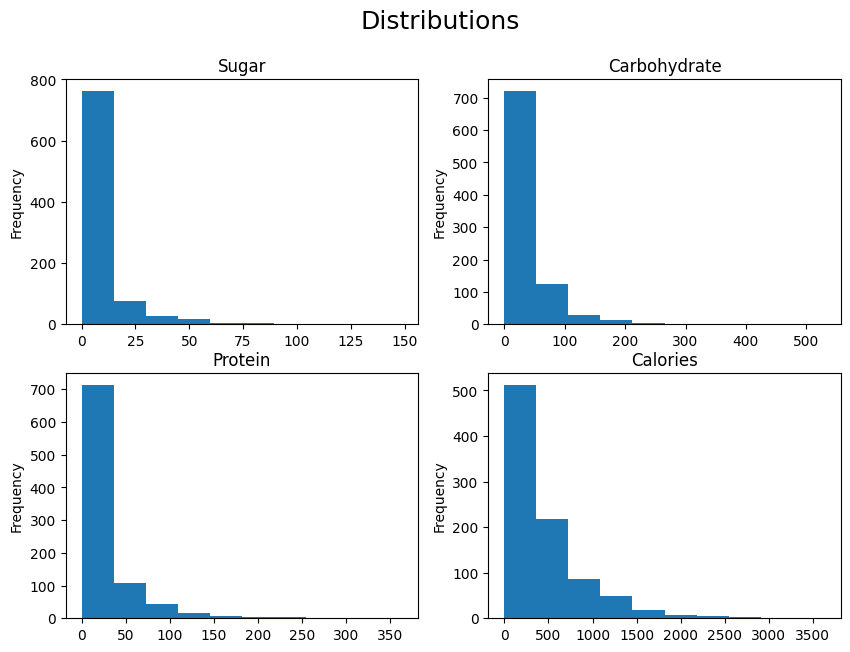

In [10]:
figure, axs = plt.subplots(2, 2, figsize=(10, 7))

df["sugar"].plot(kind="hist", ax=axs[0, 0])
axs[0, 0].set_title("Sugar")
df["carbohydrate"].plot(kind="hist", ax=axs[0, 1])
axs[0, 1].set_title("Carbohydrate")
df["protein"].plot(kind="hist", ax=axs[1, 0])
axs[1, 0].set_title("Protein")
df["calories"].plot(kind="hist", ax=axs[1, 1])
axs[1, 1].set_title("Calories")

figure.suptitle("Distributions", fontsize=18)

plt.show()

Since the data is right skewed, I'll use the median to impute the missing values because is more appropriated against not normalize data.

In [11]:
#Columns to impute
columns = ["calories", "carbohydrate", "sugar", "protein"]

In [12]:
#Table with the medians

df2 = df.copy()

table = df2.groupby(["category", "servings"])[columns].median().reset_index()
table.head()

,category,servings,calories,carbohydrate,sugar,protein
0,Beverages,1,154.465,11.120,9.385,0.400
1,Beverages,2,199.340,13.870,7.580,0.560
2,Beverages,4,129.450,12.415,9.885,0.405
3,Beverages,6,88.170,8.840,6.470,0.400
4,Breakfast,1,253.465,28.850,3.590,13.975


In [13]:
#merge the two tables so the correct values are linked to the correcto rows
df2 = df2.merge(table, on=["category", "servings"])

In [14]:
#fill in the missing values

for c in columns:
    df2[f"{c}_x"] = df2[f"{c}_x"].fillna(df2[f"{c}_y"])

In [15]:
df2 = df2.drop(["calories_y", "carbohydrate_y", "sugar_y", "protein_y"], axis=1)

In [16]:
#rename the columns to the original name
df2 = df2.rename(columns={"calories_x": "calories", 
                    "carbohydrate_x": "carbohydrate", 
                    "sugar_x": "sugar", 
                    "protein_x":"protein"})

In [17]:
df2.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,538.52,11.83,2.53,35.12,Pork,6,High
1,9,538.52,3.78,3.37,3.79,Pork,6,High
2,55,131.51,33.32,1.70,87.11,Pork,6,High
3,90,538.52,11.83,2.53,35.12,Pork,6,High
4,125,2906.01,3.52,1.89,179.22,Pork,6,High


Let's reorganize the data

In [18]:
#Organized data
df2 = df2.sort_values(by="recipe").set_index("recipe").reset_index()

At the end of the data validation section I will check the statistical relevance of the numeric data and after normalize it using log transformation since the data is positive skewed

In [19]:
df2.isna().sum()

recipe            0
calories          0
carbohydrate      0
sugar             0
protein           0
category          0
servings          0
high_traffic    373
dtype: int64

The high traffic still has null values, let's evaluate the columns remaining and check what can be done to those

In [20]:
#Check unique values for each column

columns = list(df2.select_dtypes("object").columns)

print("Unique Values for each categorical column:")
for c in columns:
    print(f"{c}: {list(df2[c].unique())}")

Unique Values for each categorical column:
category: ['Pork', 'Potato', 'Breakfast', 'Beverages', 'One Dish Meal', 'Chicken Breast', 'Lunch/Snacks', 'Chicken', 'Vegetable', 'Meat', 'Dessert']
servings: ['6', '4', '1', '2', '4 as a snack', '6 as a snack']
high_traffic: ['High', nan]


The **category** column has 11 unique values.

The **servings** columns has 6 unique values.

The **high traffic** has 1 unique value and the other are nulls so we can assume every value that's not high is low, let's fill them

## Traffic column

In [21]:
#Fill high_traffic missing values with "Low"
df2["high_traffic"] = df2["high_traffic"].fillna("Low")

## Recipe Column

There's no need to have the recipe column since the only propose of it is to attribute an ID to each recipe

In [22]:
#let's drop it

df2 = df2.drop("recipe", axis=1)

## Servings

In [23]:
df2["servings"].value_counts()

4               389
6               197
2               183
1               175
4 as a snack      2
6 as a snack      1
Name: servings, dtype: int64

Since the rows "as a snack" have almost no weight on the data, we may want to drop them later, after the analysis. For now, I will keep them because those are unique values of our servings column

## Category

In [24]:
df2["category"].value_counts()

Breakfast         106
Chicken Breast     98
Beverages          92
Lunch/Snacks       89
Potato             88
Pork               84
Vegetable          83
Dessert            83
Meat               79
Chicken            74
One Dish Meal      71
Name: category, dtype: int64

Nothing seems out of the ordinary with the category column, all unique values have a high number of recipes, within our total data recipes, and, has seen before, there's no missing values

### Statistical Relevance of the numeric data

**Null Hypothesis:** Is there no significant relationship between the nutritional values of a recipe (calories, carbohydrates, sugar, and protein) and its likelihood of generating high traffic?

In [25]:
df2.head()

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,538.52,11.83,2.53,35.12,Pork,6,High
1,35.48,38.56,0.66,0.92,Potato,4,High
2,914.28,42.68,3.09,2.88,Breakfast,1,Low
3,97.03,30.56,38.63,0.02,Beverages,4,High
4,27.05,1.85,0.80,0.53,Beverages,4,Low


In [166]:
# Store the names of the columns in a list
columns = ['calories','carbohydrate','sugar','protein']

# Divide the data into two groups: high traffic and low traffic
high_traffic = df2[df2['high_traffic'] == 'High']
low_traffic = df2[df2['high_traffic'] == 'Low']

In [170]:
#loop through the columns
results = {}
for col in columns:
    t_stat, p_val = stats.ttest_ind(high_traffic[col], low_traffic[col])
    results[col] = {'t-statistic': t_stat, 'p-value': p_val}


#results
for col in results:
    print(f'{col}: t-statistic = {results[col]["t-statistic"]:.2f}, p-value = {results[col]["p-value"]:.4f}')

calories: t-statistic = 2.15, p-value = 0.0321
carbohydrate: t-statistic = 2.24, p-value = 0.0253
sugar: t-statistic = -2.42, p-value = 0.0155
protein: t-statistic = 1.12, p-value = 0.2620


#### We can reject the null hypothesis for 'calories', 'carbohydate' and 'sugar'

For calories, carbohydrate and sugar, the p-values are less than 0.05, which means that there is a significant difference in the nutritional values between recipes with high traffic and recipes with low traffic.

Proteins fail to reject the null hypothesis so we can assume that there is no significant difference.

### Checking for outliers

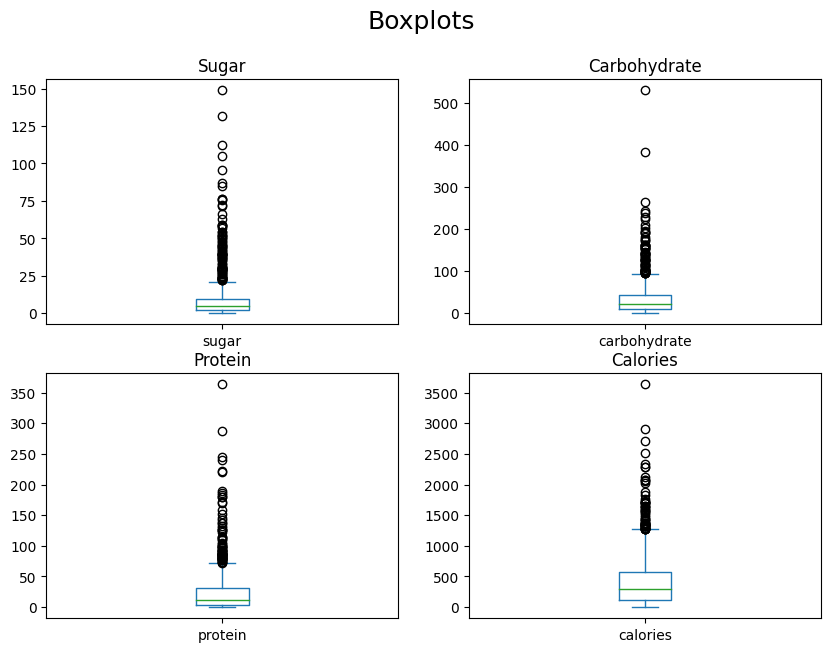

In [28]:
#Outliers

figure, axs = plt.subplots(2, 2, figsize=(10, 7))

df2["sugar"].plot(kind="box", ax=axs[0, 0])
axs[0, 0].set_title("Sugar")
df2["carbohydrate"].plot(kind="box", ax=axs[0, 1])
axs[0, 1].set_title("Carbohydrate")
df2["protein"].plot(kind="box", ax=axs[1, 0])
axs[1, 0].set_title("Protein")
df2["calories"].plot(kind="box", ax=axs[1, 1])
axs[1, 1].set_title("Calories")

figure.suptitle("Boxplots", fontsize=18)

plt.show()

There seems to be quite a few outliers, let's check how many.

In [30]:
# Calculate the interquartile range (IQR)
Q1 = df2[columns].quantile(0.25)
Q3 = df2[columns].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers using Tukey's method
outliers = df2[(df2[columns] < Q1 - 1.5 * IQR) | (df2[columns] > Q3 + 1.5 * IQR)][columns]

# Print the outliers
print("Outlier Percentage:")
outliers[columns].count() / df2.shape[0] * 100

Outlier Percentage:


calories        6.019007
carbohydrate    6.969377
sugar           8.764520
protein         7.814150
dtype: float64

The outliers represent **5 to 10 percentage** of the data, let's log the data to try and reduce them.

### Normalizing the numeric data with logarithmic transformation

In [31]:
#First let's check if the data has zero values because since the logarithm of zero is undefined, it can cause the log-transformed values to become infinite
df3 = df2.copy()

(df3[columns] == 0).sum()

calories        0
carbohydrate    0
sugar           0
protein         2
dtype: int64

In [32]:
#let's drop the zero values

df3 = df3[df3["protein"] != 0]

In [33]:
#Skewness defore normalization
df3[columns].skew()

calories        2.100878
carbohydrate    3.852445
sugar           4.268945
protein         3.582043
dtype: float64

In [34]:
#Log the data

df_norm = df3.copy()

df_norm[columns] = np.log(df_norm[columns])

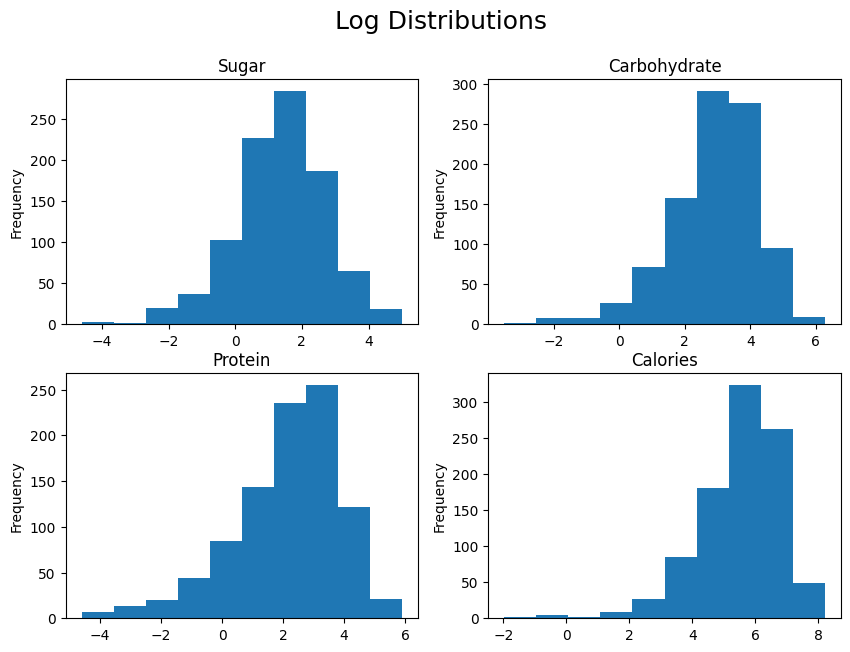

In [35]:
#Checking the new distribuitions

figure, axs = plt.subplots(2, 2, figsize=(10, 7))

df_norm["sugar"].plot(kind="hist", ax=axs[0, 0])
axs[0, 0].set_title("Sugar")
df_norm["carbohydrate"].plot(kind="hist", ax=axs[0, 1])
axs[0, 1].set_title("Carbohydrate")
df_norm["protein"].plot(kind="hist", ax=axs[1, 0])
axs[1, 0].set_title("Protein")
df_norm["calories"].plot(kind="hist", ax=axs[1, 1])
axs[1, 1].set_title("Calories")

figure.suptitle("Log Distributions", fontsize=18)

plt.show()

In [36]:
#Skeweness after normalization
df_norm[columns].skew()

calories       -1.308128
carbohydrate   -0.968480
sugar          -0.483158
protein        -0.922887
dtype: float64

Performing logarithmic transformation to the data helped making the distribution more symmetrical, let's check the outliers again.

In [37]:
# Calculate the interquartile range (IQR)
Q1 = df_norm[columns].quantile(0.25)
Q3 = df_norm[columns].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers using Tukey's method
outliers = df_norm[(df_norm[columns] < Q1 - 1.5 * IQR) | (df_norm[columns] > Q3 + 1.5 * IQR)][columns]

# Print the outliers
print(" Log data outlier percentage:")
outliers[columns].count() / df_norm.shape[0] * 100

 Log data outlier percentage:


calories        2.116402
carbohydrate    2.857143
sugar           2.116402
protein         2.539683
dtype: float64

Log tranformating the data helped a lot reducing the outliers, let's remove them so they don't affect our analysis

In [38]:
#Create dataframe with no outliers

df_norm2 = df_norm[df_norm[columns] != outliers][columns]

df_norm2[["category", "servings", "high_traffic"]] = df_norm[["category", "servings", "high_traffic"]]

df_norm2 = df_norm2.dropna()

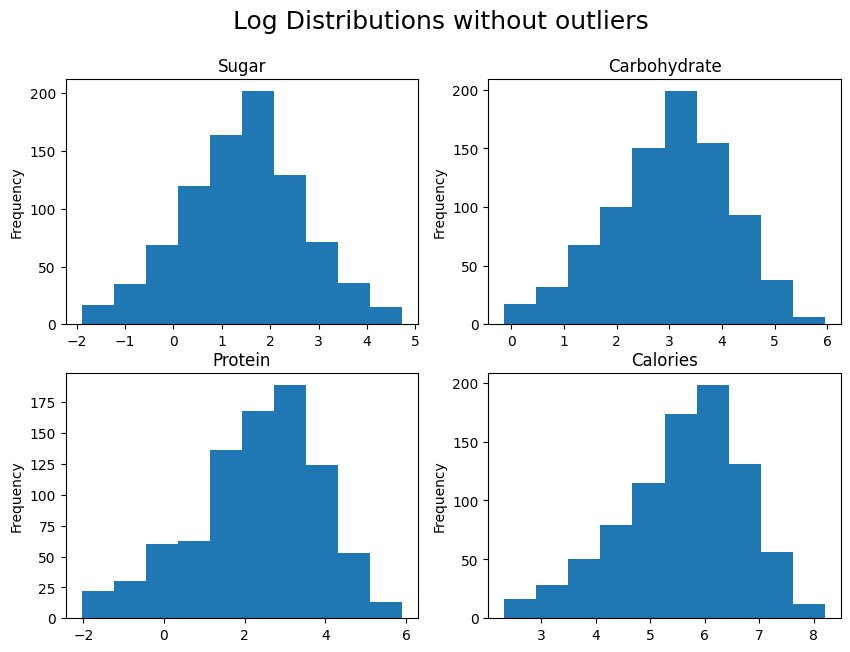

In [39]:
#Checking the new distribuitions without outliers

figure, axs = plt.subplots(2, 2, figsize=(10, 7))

df_norm2["sugar"].plot(kind="hist", ax=axs[0, 0])
axs[0, 0].set_title("Sugar")
df_norm2["carbohydrate"].plot(kind="hist", ax=axs[0, 1])
axs[0, 1].set_title("Carbohydrate")
df_norm2["protein"].plot(kind="hist", ax=axs[1, 0])
axs[1, 0].set_title("Protein")
df_norm2["calories"].plot(kind="hist", ax=axs[1, 1])
axs[1, 1].set_title("Calories")

figure.suptitle("Log Distributions without outliers", fontsize=18)

plt.show()

As we can see the data is really close to a normal distribution.

### To conclude our data validation let's convert all the columns with dtype "object" to "category" and check the data consistency using .describe()

In [41]:
#Convert object columns (category and high_traffic) to dtype category

df_norm2[["category", "servings", "high_traffic"]] = df_norm2[["category", "servings", "high_traffic"]].astype("category")

Before converting the servings column to category, we first need to analysis what the rows "as a snack" represent in the data

In [42]:
df_norm2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 858 entries, 0 to 945
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   calories      858 non-null    float64 
 1   carbohydrate  858 non-null    float64 
 2   sugar         858 non-null    float64 
 3   protein       858 non-null    float64 
 4   category      858 non-null    category
 5   servings      858 non-null    object  
 6   high_traffic  858 non-null    category
dtypes: category(2), float64(4), object(1)
memory usage: 42.4+ KB


The data is clean and read to be analyzed.

In summary:
 - Nothing seemed out of the ordinary in the nutritional columns in terms of consistency;
 - All the missing values from the **nutritional columns** were filled with the median of the grouped servings and category columns;
 - The **servings** column has 9 unique values and two of those (4 and 6 "As a snack") have a small weight on the data, nothing has been done about them, but they may be removed later;
 - The **category** columns has 11 unique values and everything seems right;
 - The **recipe** column was removed because it was merely an ID index for each recipe;
 - The **high_traffic** column had 40% missing values, which, after examination, were found to belong to the low traffic recipes. Therefore, the missing values in those rows were imputed with the value "Low";
 - The outliers were removed in order for the analysis to be performed without those affecting our takeaways.

## Exploratory Data Analysis

In [56]:
#functions

def plot_percentages_count(df, column, hue, padd, colors=None, count_color=None):
    
    """
        Takes a dataframe and two columns and return a plot with the percentages of the first column regarding the second.
        Does also return the total count of values of the first column
        
        Inputs:
            df: DataFrame
            column: first column to analyse
            hue: second column to compare to the first one
            padd: padd of the percentages shown on the bars
            colors: colors to show on the plot bars
            count_color: color of the count plot on the right
        Returns:
            Two plots, side by side, with the percentage of the first column regarding the second column and the count of the first one
    """
    
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    
    #create the dataframe with the percentages data
    temp_df = round(df.groupby(column)[hue].value_counts() / df.groupby(column)[hue].count() * 100, 1)
    temp_df = temp_df.to_frame("percentage").reset_index()
    temp_df.head(6)

    pivot_temp_df = temp_df.pivot(index=column, columns="level_1", values="percentage").reset_index()
    pivot_temp_df.index.rename("index", inplace=True)

    pivot_temp_df[column] = pivot_temp_df[column].str.title()

    sns.set_style("white")
    if colors == None:
        palette = sns.color_palette("mako_r")
        palette.reverse()
        colors = palette[-3:]
        
    if count_color == None:
        count_color = "blue"

    pivot_temp_df = pivot_temp_df[[column, "High", "Low"]]
    pivot_temp_plot = pivot_temp_df.sort_values(["High"], ascending=True)

    pivot_temp_plot = pivot_temp_plot.reset_index().drop("index", axis=1)
    
    #create the dataframe with the counts
    servings_count = df[column].value_counts().to_frame("count").reset_index()
    
    servings_count["index"] = servings_count["index"].str.title()
    
    resut = pivot_temp_plot.merge(servings_count, left_on=column, right_on="index").drop("index", axis=1)
    
    #plot the charts
    figure, axs = plt.subplots(1, 2, figsize=(11, 6), sharey=True, gridspec_kw={'width_ratios': [3, 1]})
    plt.subplots_adjust(wspace=0.02, hspace=0)
    
    #Right chart
    resut.plot(kind="barh", y="count", ax=axs[1], color=count_color, label="Count")

    for bars in axs[1].containers:
        axs[1].bar_label(bars, labels=[f"{c}" for c in bars.datavalues],
                     padding=2, color="black", fontsize=10)
        break

    #Main Chart
    resut.plot(x=column, y=["High", "Low"], kind="barh", stacked=True, fontsize=14, mark_right=True, width=0.68, color=colors, ax=axs[0])

    for bars in axs[0].containers:
        axs[0].bar_label(bars, labels=[f"{c}%" for c in bars.datavalues],
                     padding=padd, color="white", fontweight="bold", fontsize=10)
        break

    #axs[0].legend(bbox_to_anchor=(0.75, 1.1), ncol=3)
    plt.subplots_adjust(bottom=0.3)
    axs[0].set_title(f"Percentage of high traffic per {column}",pad=40, fontdict={"fontsize":22})
    axs[0].set_xlabel("Percentage %")
    axs[0].set_ylabel(column)
    axs[0].legend(bbox_to_anchor=(0.65, 1.1), ncol=3)
    
    #chart configs
    axs[1].set_xticklabels([])
    axs[1].spines['bottom'].set_visible(False)
    axs[1].legend().remove()
    
    plt.text(0, len(df[column].unique()), "Amout of Recipes")
    sns.despine()
    
    plt.show()
    
def numeric_cols_analysis(df, log_df, column, fig_size):
    
    """
        Takes in a dataframe and one column and returns 4 plots with distributions and descriptive statistics of that column a the           traffic column.
        
        Inputs:
            df: DataFrame
            column: column to analyse against traffic
            fig_size: tuple of values to change the dimensions of the multiple plots
        Returns:
            Four plots, with distributions and descriptive statistics
    """
    
    fig, axs = plt.subplots(2, 2, figsize=(fig_size))
    sns.set_palette(colors)

    #First Plot - Normal Data KDE
    ax1 = sns.kdeplot(data=df, x=column, hue="high_traffic", ax=axs[0, 0], legend=False).set(title=f'Distribution of the {column.capitalize()} per Traffic')
    

    #Second Plot - Log Scale Data KDE
    ax2 = sns.kdeplot(log_df, x=column, hue="high_traffic", ax=axs[0, 1], legend=False).set(title=f'Log Distribution of the {column} per Traffic')

    #Third Plot - Boxplot normal data
    ax3 = sns.boxplot(x=column, y="high_traffic", data=log_df, ax=axs[1, 0]).set(title=f'Log Boxplot of the {column} per Traffic')
    axs[1, 0].set_ylabel('Traffic')

    #Fourth Plot - Boxplot normal data with categories
    ax4 = sns.boxplot(data=log_df, x=column, y="category", hue="high_traffic", ax=axs[1, 1]).set(title=f'Log Boxplot of the {column} per Traffic regarding the Categories')
    
    plt.legend().remove()

    #Figure settings
    fig.suptitle(f'{column.capitalize()}', fontsize=24)
    fig.legend(bbox_to_anchor=(0.56, 0.51), ncol=2)
    plt.subplots_adjust(wspace=0.2, hspace=0.4)

    plt.show()

In [57]:
#Plof config

#colors: red: #ec5966, grey: #b3aba3, greyish:#ddd0c6

colors = ["#ec5966", "#a8aaad", "#4d4845"]

sns.set_palette(colors)

# Traffic Column

In [58]:
#Percentage of high and low traffic recipes
df_norm2.high_traffic.value_counts() / df_norm2.high_traffic.count() * 100

High    61.871345
Low     38.128655
Name: high_traffic, dtype: float64

# Categorical Columns

## Category vs High Traffic

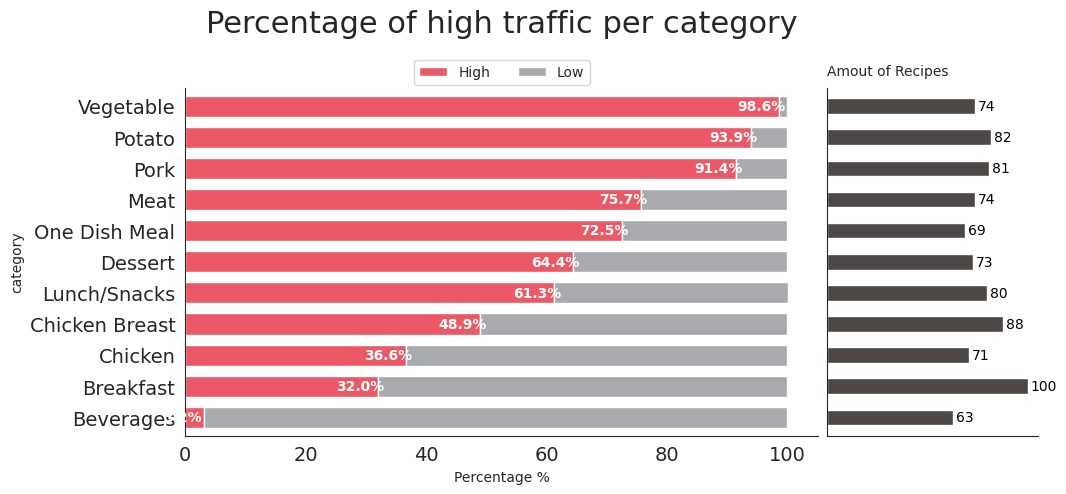

In [59]:
plot_percentages_count(df_norm2, "category", "high_traffic", -30, colors, count_color=colors[2])

As showed in the chart, there are some categories with a high traffic (Vegetable, Potato and Pork) and others with low traffic like Chicken, Breakfast and, with the lowest traffic, Beverages, so is fair to assume that the Category column has a big weight on a recipe having high or low traffic

## Servings vs High Traffic

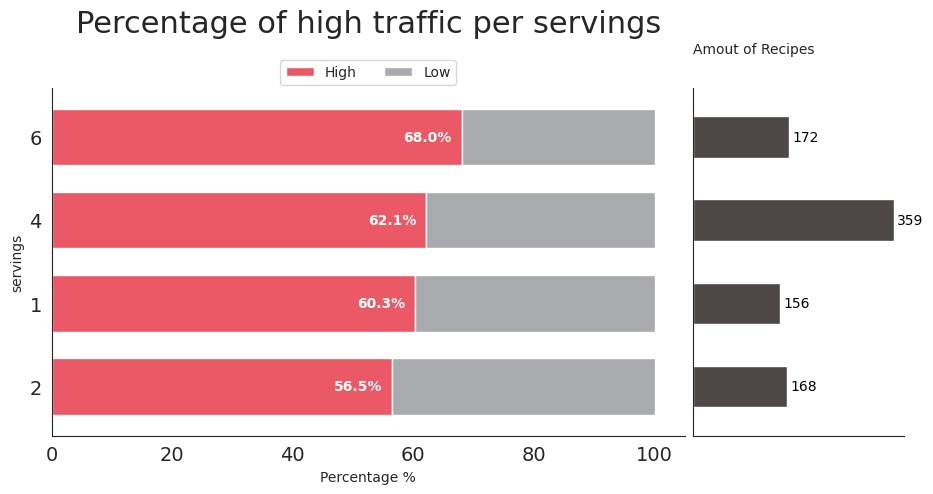

In [60]:
plot_percentages_count(df_norm2, "servings", "high_traffic", -42, colors, count_color=colors[2])

Putting aside the "6 As A Snack" serving, because entries quantity is so low, it becames insignificant, we can observe that recipes with 6 servings have more traffic and with 2 have the lowest, eventhought there's not a significant difference

# Numeric Columns

## Calories vs High Traffic

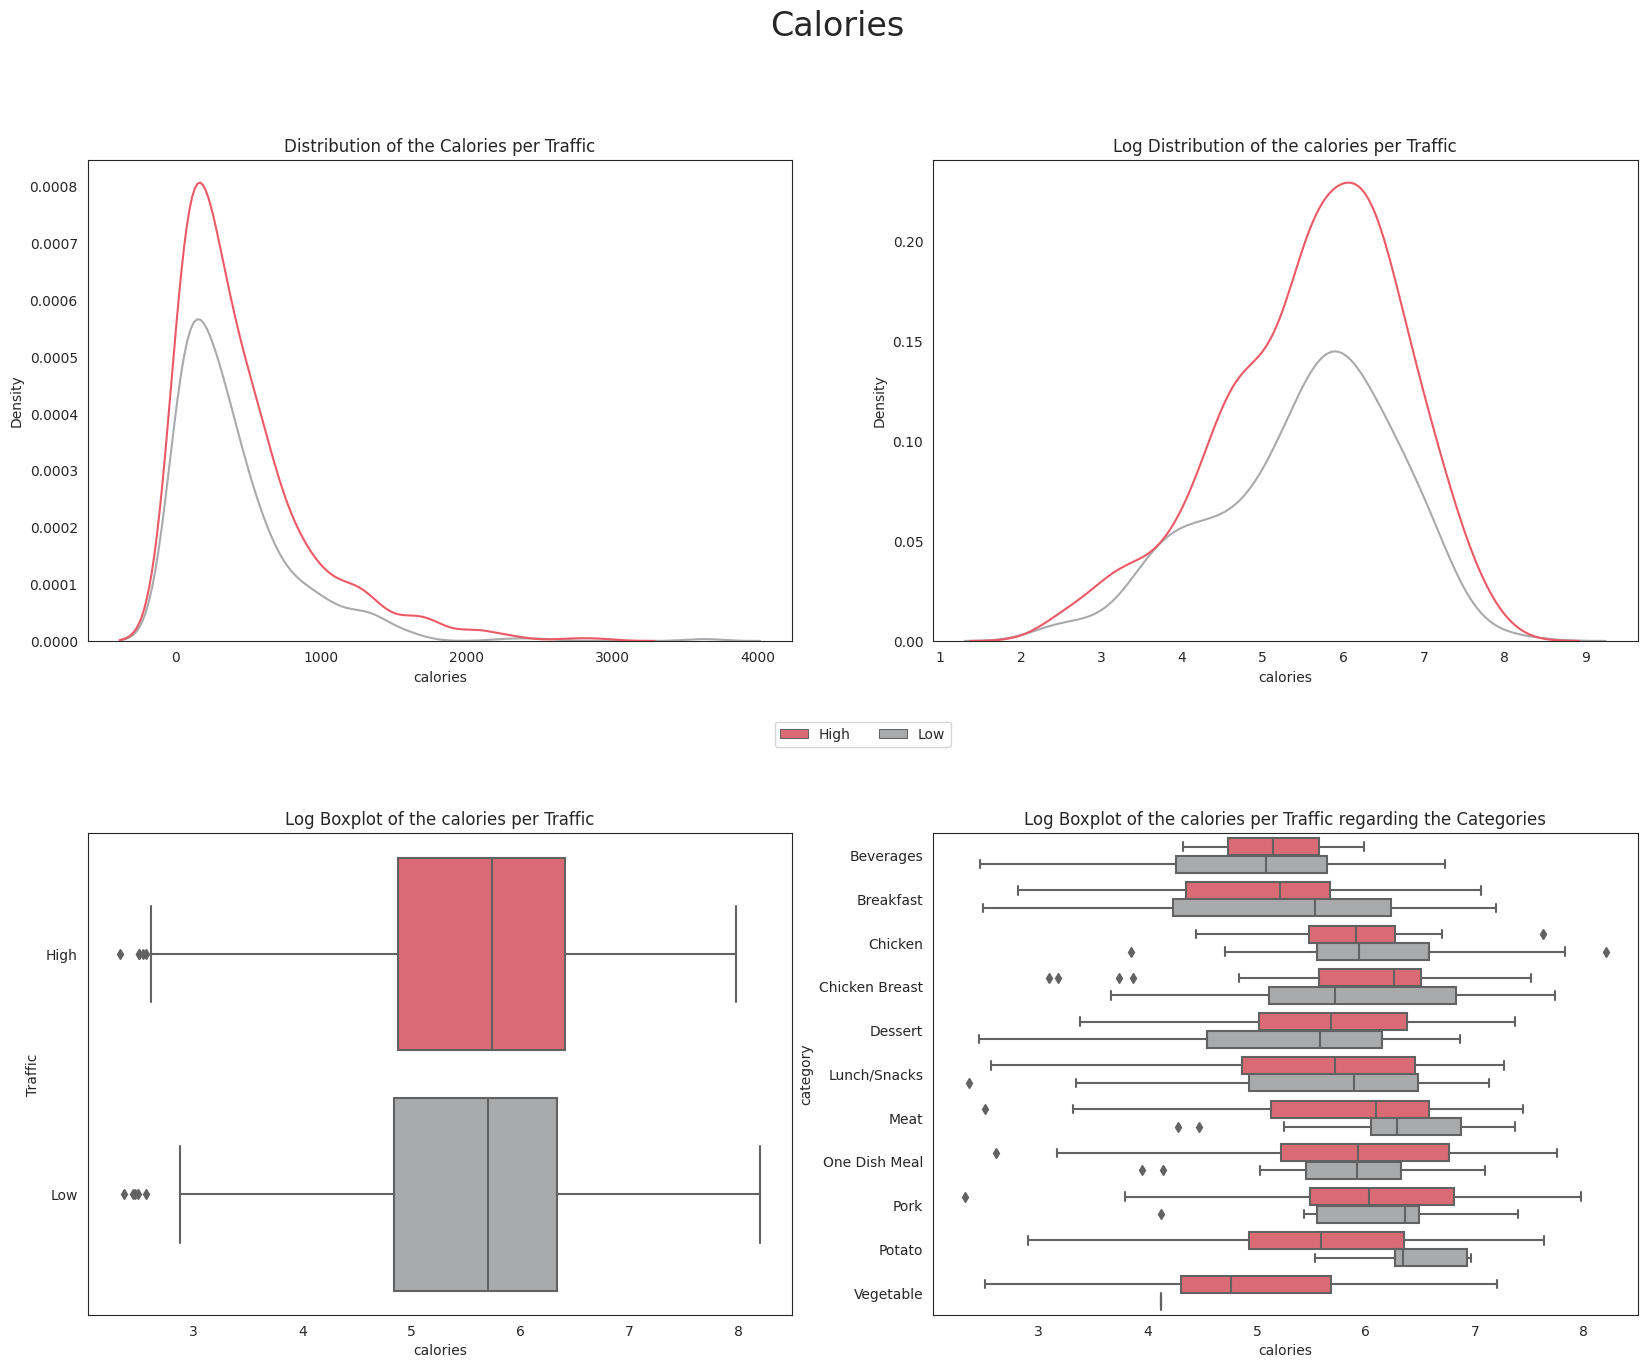

In [61]:
numeric_cols_analysis(df3, df_norm2, "calories", (20, 15))

There's no significant different on the descriptive statistics of calories columns regarding the traffic

## Carbohydrates vs High Traffic

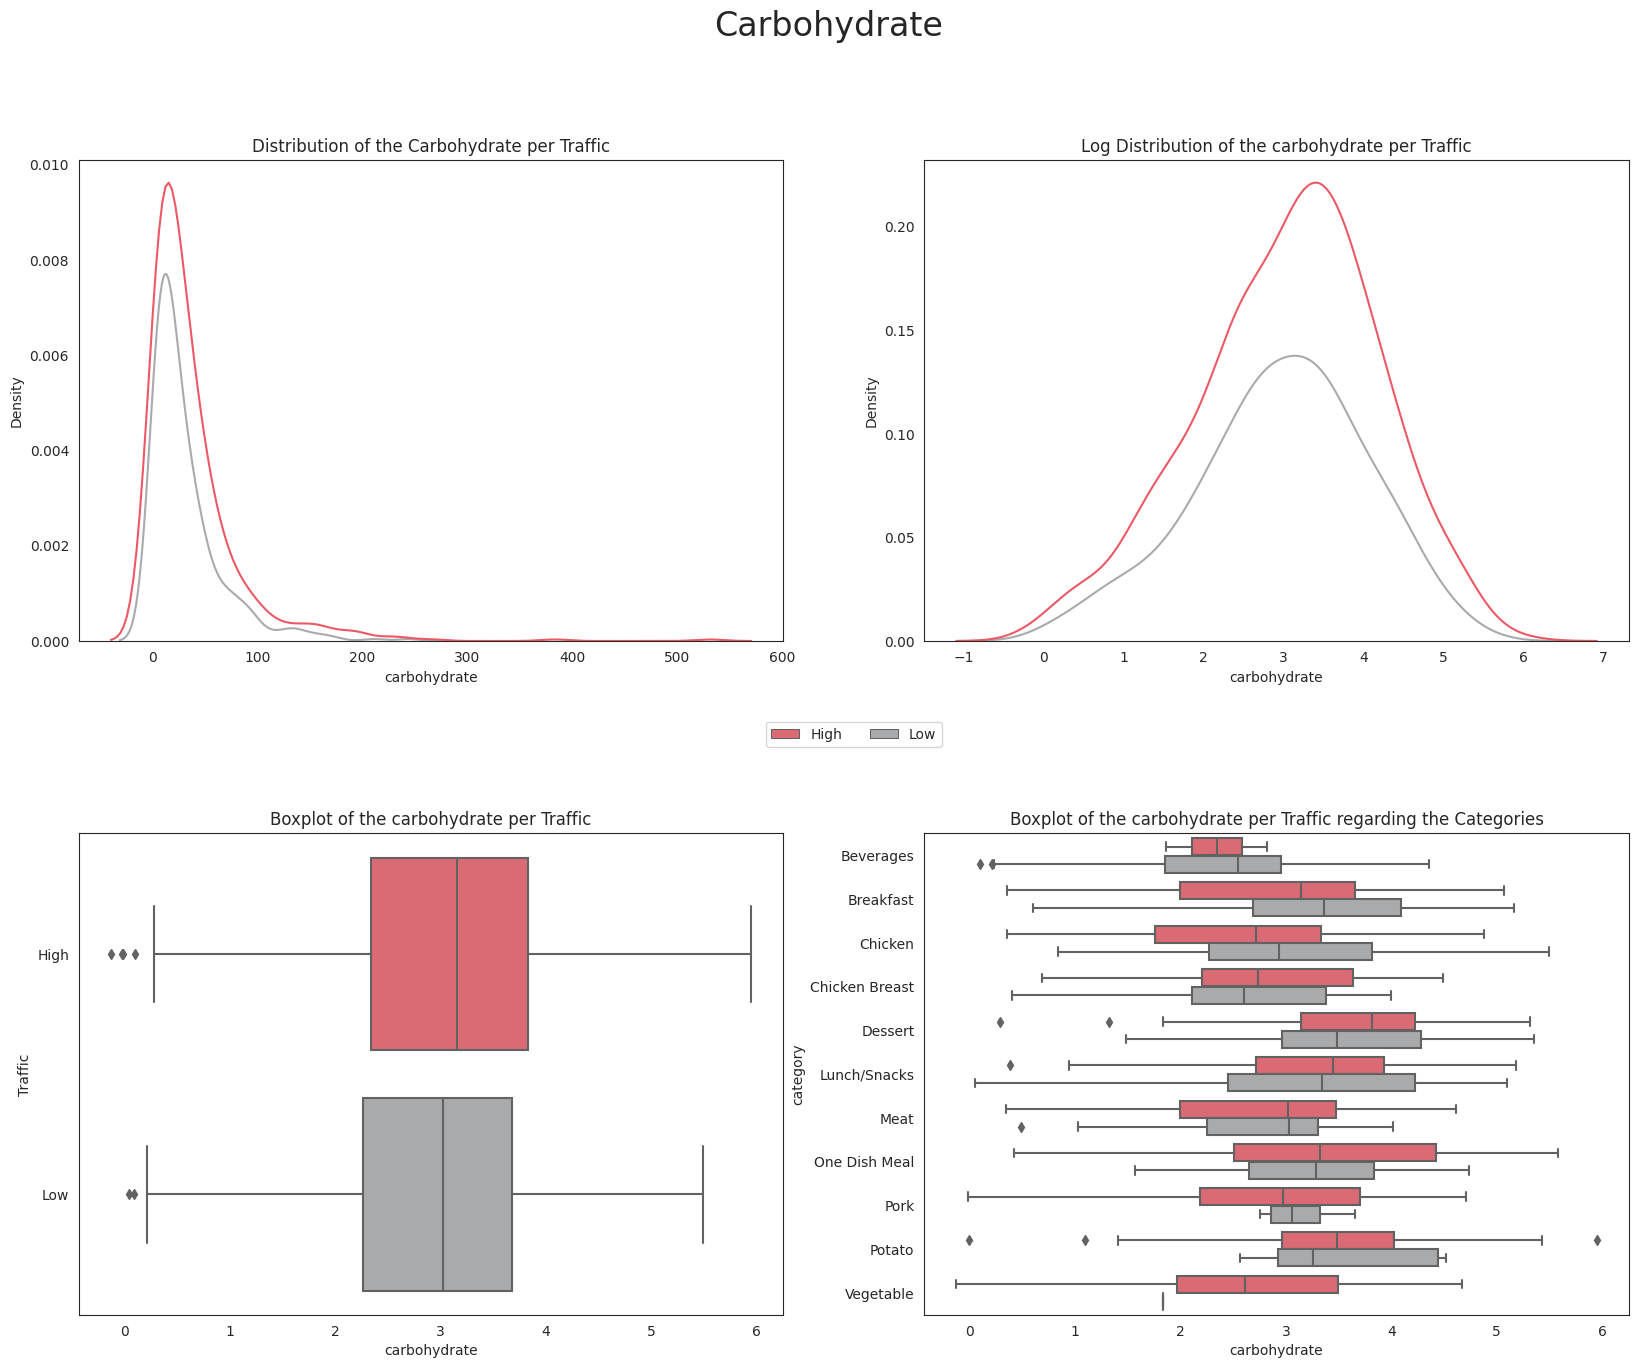

In [49]:
numeric_cols_analysis(df3, df_norm2, "carbohydrate", (20, 15))

We can see the carbohydrate column is similar to the previous (calories)

## Sugar vs Traffic

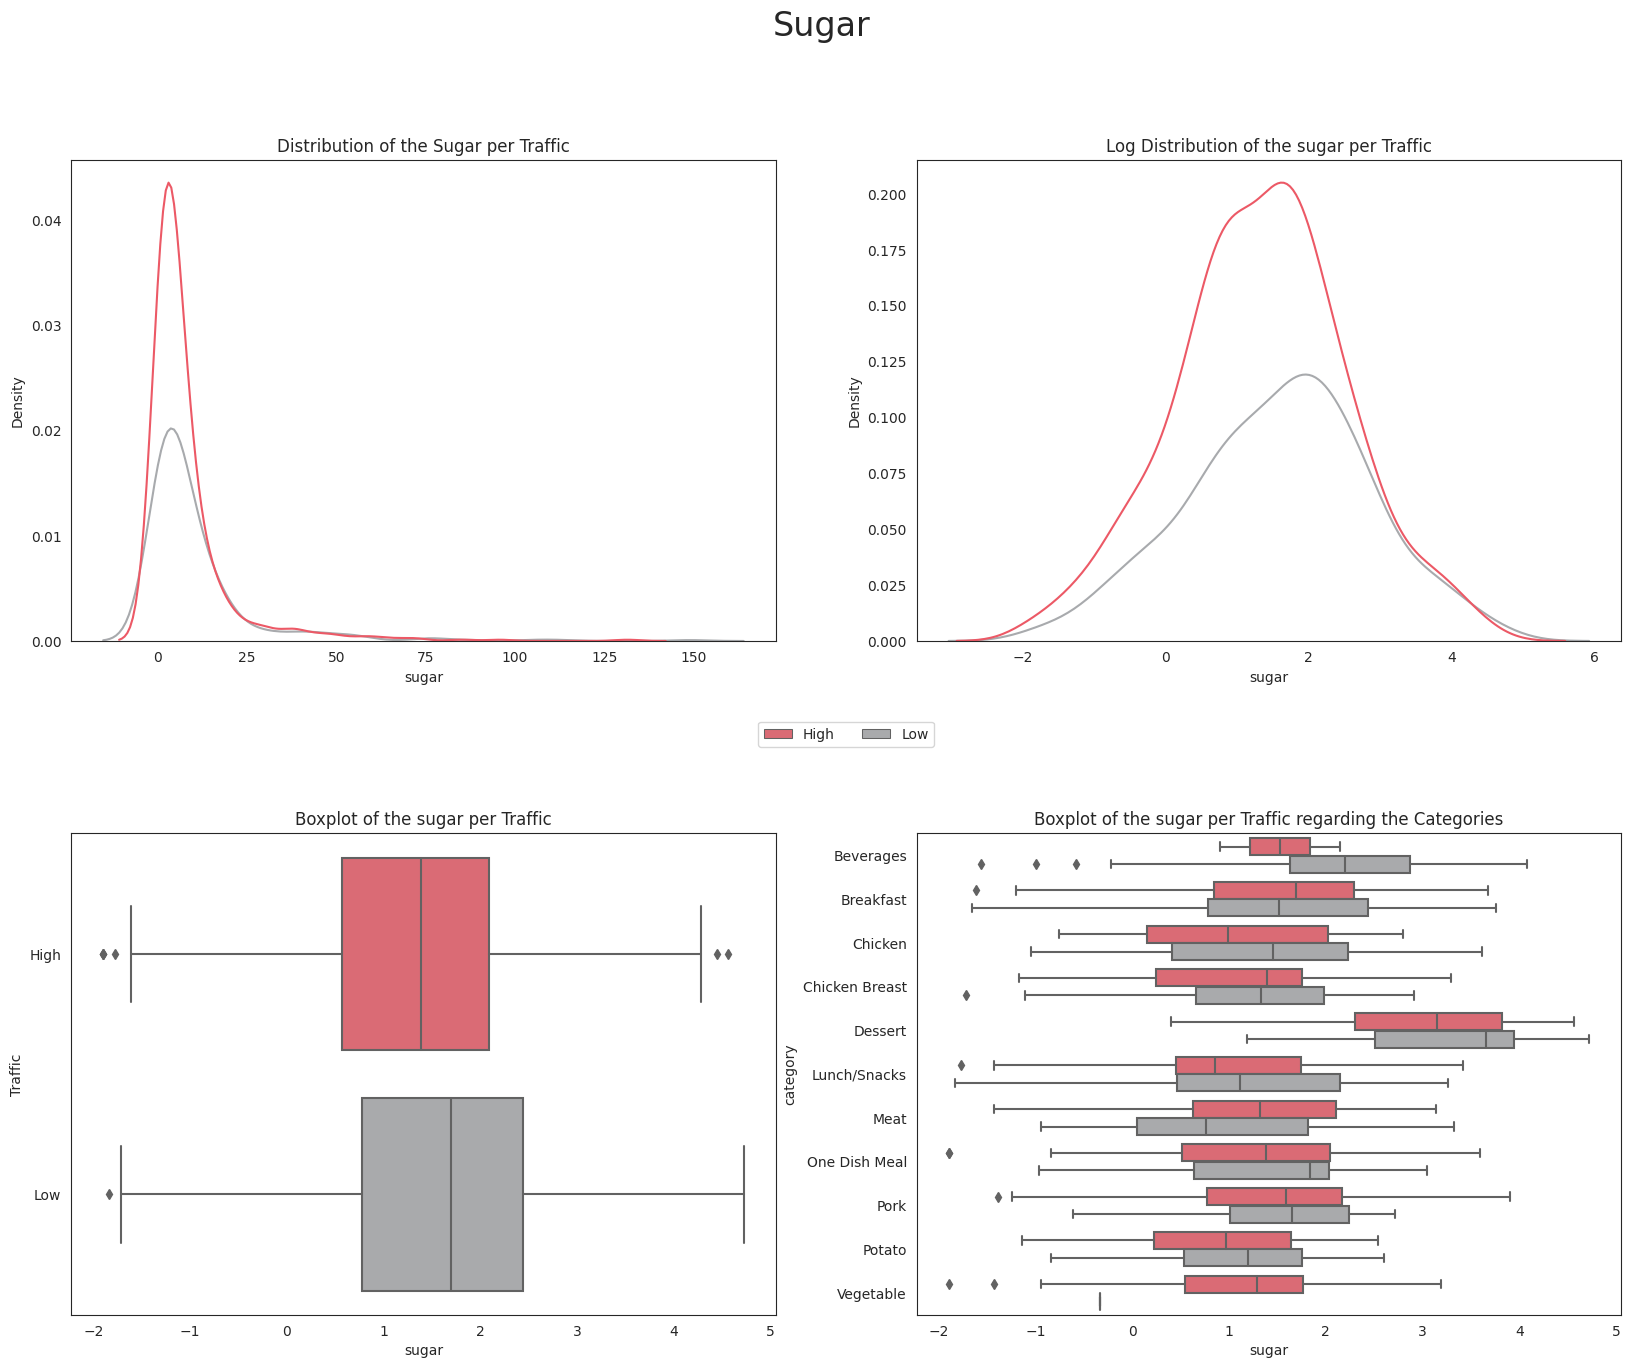

In [50]:
numeric_cols_analysis(df3, df_norm2, "sugar", (20, 15))

## Protein vs Traffic

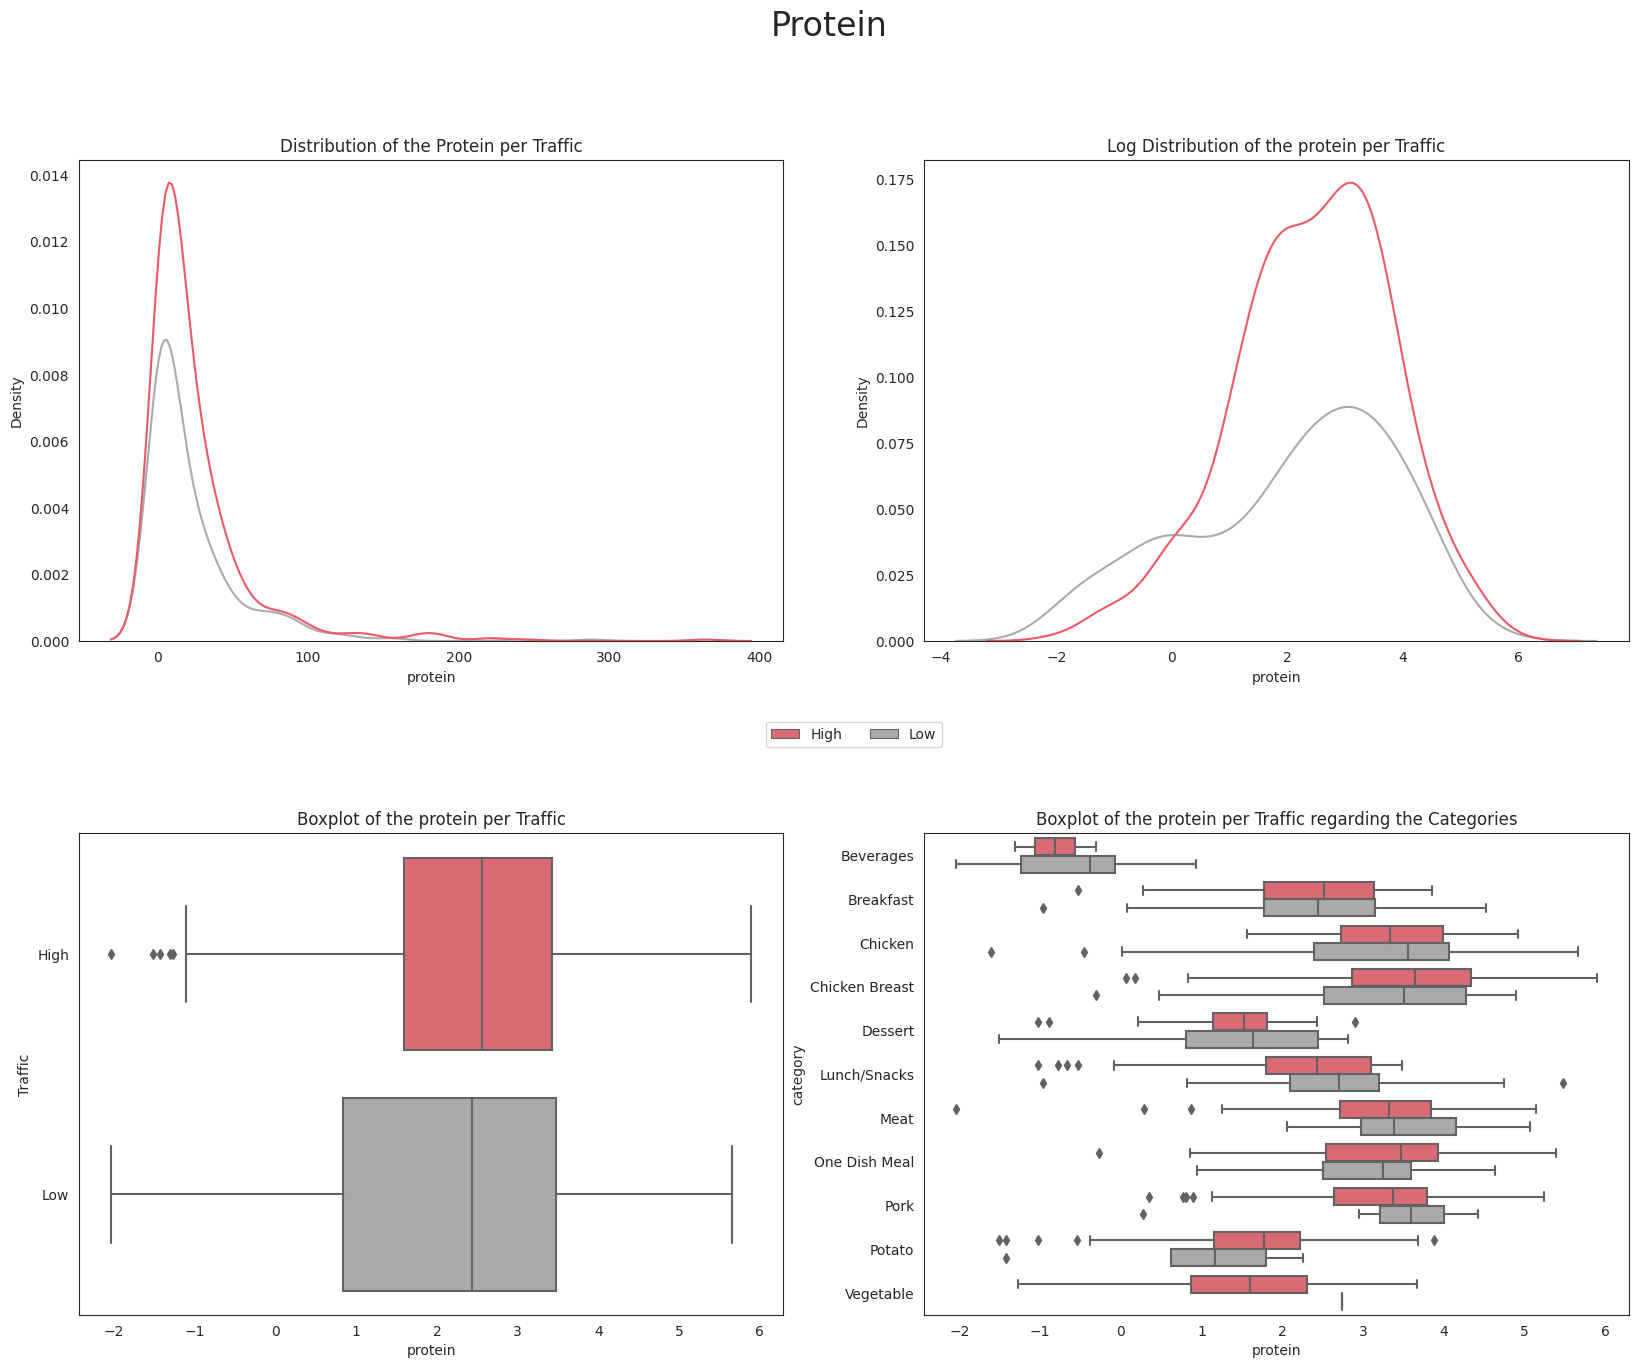

In [51]:
numeric_cols_analysis(df3, df_norm2, "protein", (20, 15))

## Compare all nutricional columns

In [52]:
#create new dataframe with only the columns we want, their values and the traffic associated
data_melt = pd.melt(df_norm2, id_vars=['high_traffic'], value_vars=['calories', 'sugar', 'protein', 'carbohydrate'], var_name='Columns')

In [53]:
data_melt.head()

,high_traffic,Columns,value
0,High,calories,6.288825
1,High,calories,3.568969
2,Low,calories,6.818137
3,Low,calories,3.297687
4,High,calories,6.538357


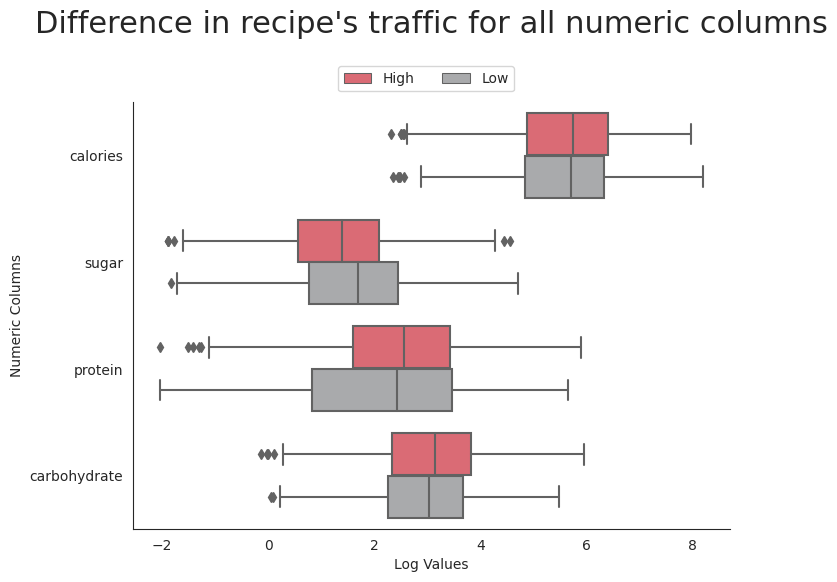

In [54]:
#boxplot of all nutritional columns

ax = sns.catplot(x='value', y='Columns', hue='high_traffic', kind='box', data=data_melt, legend=False, aspect=1.5, palette=colors)
plt.title("Difference in recipe's traffic for all numeric columns", pad=50, fontdict={"fontsize":22})

plt.xlabel("Log Values")
plt.ylabel("Numeric Columns")
plt.legend(bbox_to_anchor=(0.65, 1.1), ncol=3)

sns.despine()
plt.show()

#### Overall, the Calories, Sugar, Carbohydrate and Protein, are pretty similar when analyzing the connection with the traffic column. Taking a look at the distributions the high traffic recipes have a higher density, but that can be explained by the fact that, those represent 60% of the data

Is possible that, in model development those columns would not contribute to must for the final score, so those will be removed from the data and the dropped rows will be added to the data frame, so we can have a bigger dataset to train and test

# Correlation

In [114]:
#drop the 3 rows with "4 as a snack" and "6 as a snack" because they don't have any weight in the data for the work needed to convert them to our model
to_remove = ["4 as a snack", "6 as a snack"]

#remove the rows
df_norm2 = df_norm2[~df_norm2.servings.isin(to_remove)]

#convert "servings" to float
df_norm2["servings"] = df_norm2["servings"].astype("float")

<AxesSubplot:>

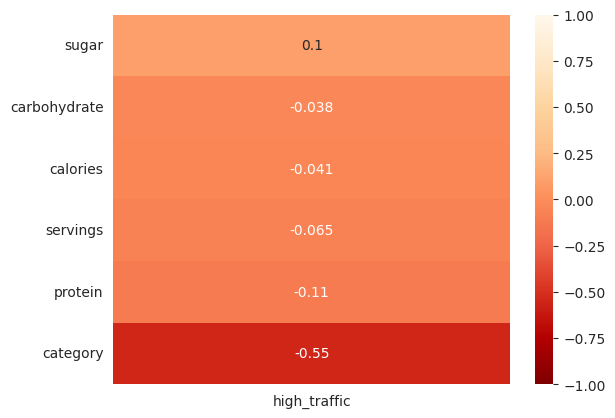

In [115]:
#copy numeric columns from main df
pre_corr_df = df_norm2.copy()

#Binary Encode high_traffic column
pre_corr_df["high_traffic"] = pre_corr_df["high_traffic"].map({"High":0, "Low":1})

#create new dataframe to use later and Label Encode "category" column
corr_df = pre_corr_df.copy()
corr_df["category"] = pre_corr_df["category"].cat.codes

#convert categories to float
corr_df[["category", "high_traffic"]] = corr_df[["category", "high_traffic"]].astype("float")

#Plot corr
corr_df = corr_df.corr()
#mask = np.triu(np.ones_like(corr_df, dtype=bool))
sns.heatmap(corr_df["high_traffic"].to_frame().drop("high_traffic", axis=0).sort_values(by="high_traffic", ascending=False), annot=True, cmap="OrRd_r", vmin=-1, vmax=1)

It appears that the recipes category has the strongest correlation with the traffic it receives.

# Model Development

Things to consider:
 - If, according to the correlation matrix, the columns for calories, sugar, protein, and carbohydrates do not improve our model, let's remove them and add back the rows that were dropped when validating the data.

In [132]:
#Encoding values

df_enc = df_norm2.copy()

In [133]:
#OneHotEncoding the category and servings columns
from sklearn.preprocessing import LabelEncoder

#One Hot Encode columns "category" and "servings"
df_enc = pd.get_dummies(df_enc, columns=["category"], prefix='cat')
df_enc = pd.get_dummies(df_enc, columns=["servings"], prefix='serv')

In [134]:
#Label Encoding the Target (high_traffic) column

le = LabelEncoder()
df_enc.high_traffic = le.fit_transform(df_enc.high_traffic)

In [135]:
df_enc.head()

,calories,carbohydrate,sugar,protein,high_traffic,cat_Beverages,cat_Breakfast,cat_Chicken,cat_Chicken Breast,cat_Dessert,cat_Lunch/Snacks,cat_Meat,cat_One Dish Meal,cat_Pork,cat_Potato,cat_Vegetable,serv_1.0,serv_2.0,serv_4.0,serv_6.0
0,6.288825,2.470639,0.928219,3.558771,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,3.568969,3.652215,-0.415515,-0.083382,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,6.818137,3.753730,1.128171,1.057790,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
4,3.297687,0.615186,-0.223144,-0.634878,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5,6.538357,1.241269,0.500775,3.987687,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


In [136]:
df_enc.shape

(855, 20)

# Model evaluation

As this is a binary classification problem with only two possible outcomes (High or Low), we will try four different classification models (Ridge Classifier, Gaussian Naive Bayes, Bernoulli Naive Bayes, and Logistic Regression) and compare their performance to determine which one works best for our data.

In [121]:
#Dependencies
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB

In [137]:
#function

def eval_models(data):
    
    """
        Evaluates, on four models (Logistic Regression, Ridge Classifier, Gaussian Naives Bayes and Bernoulli Naive Bayes), the accuracy, precision, f1 and Recal metrics.
        Input: Dataframe to test
        Output: Returns a Dataframe with the evaluations for each model on the provided data
    """
    
    X = data.drop("high_traffic", axis=1)
    y = data["high_traffic"]
    
    evaluations = pd.DataFrame(index=["Accuracy", "Precision", "Recall", "F1"])
    
    #Logistic Regression
    lr = LogisticRegression()
    scores = cross_validate(lr, X, y, cv=5, scoring=["accuracy", "precision", "recall", "f1"])
    
    evaluations["Logistic Regression"] = [round(scores['test_accuracy'].mean(), 4) * 100, 
                                         round(scores['test_precision'].mean(), 4) * 100,
                                         round(scores['test_recall'].mean(), 4) * 100,
                                         round(scores['test_f1'].mean(), 4) * 100]

    #Ridge Classifier
    rc = RidgeClassifier()
    scores = cross_validate(rc, X, y, cv=5, scoring=["accuracy", "precision", "recall", "f1"])
    
    evaluations["Ridge Classifier"] = [round(scores['test_accuracy'].mean(), 4) * 100, 
                                         round(scores['test_precision'].mean(), 4) * 100,
                                         round(scores['test_recall'].mean(), 4) * 100,
                                         round(scores['test_f1'].mean(), 4) * 100]
    
    #Gaussian Naive Bayes
    gnb = GaussianNB()
    scores = cross_validate(gnb, X, y, cv=5, scoring=["accuracy", "precision", "recall", "f1"])

    evaluations["Gaussian Naive Bayes"] = [round(scores['test_accuracy'].mean(), 4) * 100, 
                                     round(scores['test_precision'].mean(), 4) * 100,
                                     round(scores['test_recall'].mean(), 4) * 100,
                                     round(scores['test_f1'].mean(), 4) * 100]
    
    #Bernoulli Naive Bayes
    bnb = BernoulliNB()
    scores = cross_validate(bnb, X, y, cv=5, scoring=["accuracy", "precision", "recall", "f1"])

    evaluations["Bernoulli Naive Bayes"] = [round(scores['test_accuracy'].mean(), 4) * 100, 
                                     round(scores['test_precision'].mean(), 4) * 100,
                                     round(scores['test_recall'].mean(), 4) * 100,
                                     round(scores['test_f1'].mean(), 4) * 100]
    
    return evaluations.style.highlight_max(color='yellow', axis = 1)

In [138]:
eval_models(df_enc)

,Logistic Regression,Ridge Classifier,Gaussian Naive Bayes,Bernoulli Naive Bayes
Accuracy,75.910000,76.140000,71.350000,74.040000
Precision,71.930000,71.850000,59.300000,69.800000
Recall,62.300000,63.530000,83.160000,58.610000
F1,66.300000,66.920000,68.850000,63.180000


After a first evaluation we got an accuracy of 76% and a precision of 72% on our best model.

In [139]:
#Adding back all the values

df_final = df2.copy()

#One Hot Encode and Label Encode the dataset

df_final = pd.get_dummies(df_final, columns=["category"], prefix='cat')
df_final = pd.get_dummies(df_final, columns=["servings"], prefix='serv')

le = LabelEncoder()
df_final.high_traffic = le.fit_transform(df_final.high_traffic)

#Remove the 4 columns

df_final = df_final.drop(["calories", "carbohydrate", "sugar", "protein"], axis=1)

In [140]:
df_final.head()

,high_traffic,cat_Beverages,cat_Breakfast,cat_Chicken,cat_Chicken Breast,cat_Dessert,cat_Lunch/Snacks,cat_Meat,cat_One Dish Meal,cat_Pork,cat_Potato,cat_Vegetable,serv_1,serv_2,serv_4,serv_4 as a snack,serv_6,serv_6 as a snack
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [141]:
eval_models(df_final)

,Logistic Regression,Ridge Classifier,Gaussian Naive Bayes,Bernoulli Naive Bayes
Accuracy,76.560000,76.140000,64.950000,76.030000
Precision,73.360000,71.930000,57.220000,70.980000
Recall,65.190000,65.990000,84.620000,67.330000
F1,68.570000,68.440000,64.440000,68.720000


Since having the 4 columns doesn't help much, let's continue without them, as it will be less computationally intensive.

In [142]:
df2.shape

(947, 7)

In [143]:
df_final.shape

(947, 18)

### Our best performing model is Logistic Regression, so let's perform hyperparameter tuning on it.

# Hyperparameter Tunning

In [144]:
#Basic Hyperparameter Tunning
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, f1_score

In [145]:
X = df_final.drop("high_traffic", axis=1)
y = df_final["high_traffic"]

In [146]:
model = LogisticRegression()

In [150]:
#Because of compatibality issues between the solvers and the panalties, let's check first wich solver to use

solvers = ["lbfgs", "newton-cg"]
c_values = [100, 10, 1.0, 0.1, 0.01, 0.001]

# Define the scoring functions
scorer_precision = make_scorer(precision_score)
scorer_accuracy = make_scorer(accuracy_score)
scorer_f1 = make_scorer(f1_score)

scoring={'accuracy': scorer_accuracy,
         'precision': scorer_precision,
         'f1': scorer_f1}

In [151]:
#Let's add cross validation and a grid search to our model and train the model

grid = dict(solver=solvers, 
            C=c_values)

cv = RepeatedStratifiedKFold(n_splits=5, 
                             n_repeats=3, 
                             random_state=45)

grid_search = GridSearchCV(estimator=model,
                                 param_grid=grid, 
                                 n_jobs=-1, 
                                 cv=cv, 
                                 scoring=scoring, 
                                 refit="accuracy")

grid_result = grid_search.fit(X, y)

In [152]:
# Get the best parameters and best scores
best_params = grid_search.best_params_
best_scores = grid_search.best_score_

print("Best parameters:", best_params)
print("Best scores:", best_scores)

Best parameters: {'C': 1.0, 'solver': 'lbfgs'}
Best scores: 0.7669915529564653


In [153]:
hyper_results = dict()
for i, c in enumerate(grid_search.cv_results_["params"]):
    hyper_results[f"test {i}"] = {"solver":c["solver"], 
                                  "C":c["C"], 
                                  "Accuracy":grid_search.cv_results_[f"split{i}_test_accuracy"][grid_search.cv_results_[f"split{i}_test_accuracy"] > 0].mean(), 
                                  "Precision":grid_search.cv_results_[f"split{i}_test_precision"][grid_search.cv_results_[f"split{i}_test_precision"] > 0].mean(), 
                                  "F1":grid_search.cv_results_[f"split{i}_test_f1"][grid_search.cv_results_[f"split{i}_test_f1"] > 0].mean()}

In [154]:
hyper_results_df = pd.DataFrame.from_dict(hyper_results, orient="index")
hyper_results_df

,solver,C,Accuracy,Precision,F1
test 0,lbfgs,100.000,0.713158,0.756378,0.671211
test 1,newton-cg,100.000,0.732456,0.764011,0.730419
test 2,lbfgs,10.000,0.680776,0.673065,0.596300
test 3,newton-cg,10.000,0.716931,0.709823,0.706979
test 4,lbfgs,1.000,0.707231,0.752315,0.658915
test 5,newton-cg,1.000,0.711404,0.737907,0.677268
test 6,lbfgs,0.100,0.697368,0.694323,0.659537
test 7,newton-cg,0.100,0.723104,0.758367,0.696716
test 8,lbfgs,0.010,0.711640,0.717304,0.681432
test 9,newton-cg,0.010,0.710758,0.754274,0.666667


We can use any solver because they all perform similarly

Let's check penalties and more C values around the 1 value

In [155]:
#The LBFGS solver does not support L1 penalty, so we will use only L2 regularization or no regularization (None).

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=45)

pen = ["l2", "none"]

for p in pen:
    model = LogisticRegression(solver="lbfgs", C=1, penalty=p)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{p} - Accuracy: {accuracy_score(y_test, y_pred)}")

l2 - Accuracy: 0.7684210526315789
none - Accuracy: 0.7684210526315789


The results are equal, so let's not use regularization.

In [156]:
#Best C value
lista_cs = np.arange(0.01, 1, 0.01)
metric_values = {}

for c in lista_cs:
    model = LogisticRegression(solver="lbfgs", C=c)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    metric_values[c] = {"Accuracy":accuracy_score(y_test, y_pred), "Precision":precision_score(y_test, y_pred), "F1":f1_score(y_test, y_pred)}
    
metric_values_df = pd.DataFrame.from_dict(metric_values, orient="index")

<AxesSubplot:>

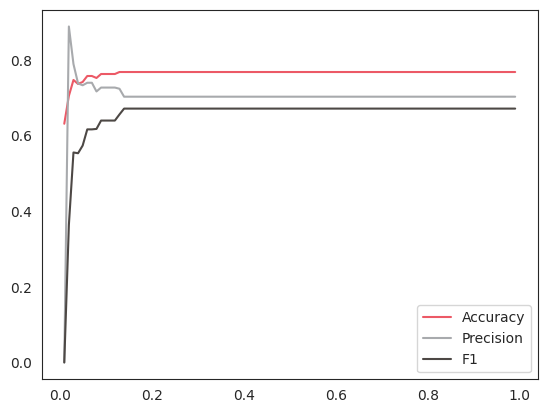

In [157]:
metric_values_df.plot()

C stabilizes at around 0.2 so let's use that as our value

## Final model and scoring

 - For our scoring, since the focus is to predict which recipes will lead to high traffic 80% of the time, the best scoring metric is precision, which only takes into account the percentage of correct prediction of high traffic recipes.
 - Accuracy is also import because we want a model wich can predict both labels (high and low) as accurate as posible.  

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=45)

lr = LogisticRegression(solver="lbfgs", C=0.2)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_test, y_pred), 4) * 100}%") 

Accuracy: 76.84%


Even though Precision is the best metric for our problem, we can't use the precision_score function from sklearn because it considered the true labels as being 1 and the Label Encoder on the preprocessing phase classified the high_traffic recipes with a zero, so let's do it manually

In [160]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[101,  19],
       [ 25,  45]])

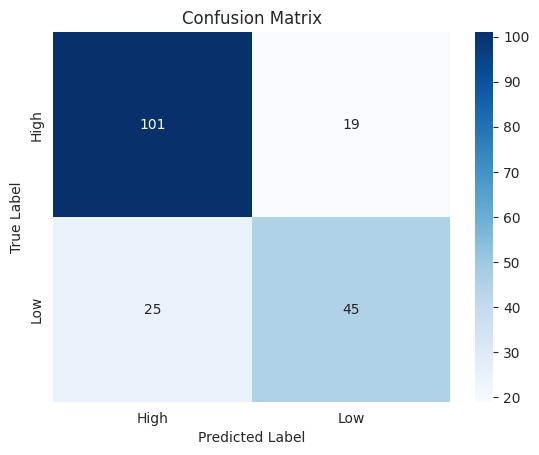

In [161]:
# Plot matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.yticks([0.5, 1.5], labels=["High", "Low"])
plt.xticks([0.5, 1.5], labels=["High", "Low"])
plt.title('Confusion Matrix')
plt.show()

In [162]:
#Using the Confunsion Matrix as the reference, the true positives are 101 and the false positives are 19

tp, fp = cm[0]
fn, tn = cm[1]

high_traffic_precision = tp / (tp + fp)

print(f"Precision Score of the high traffic recipes: {round(high_traffic_precision * 100, 2)}%")

Precision Score of the high traffic recipes: 84.17%


In [163]:
#Precision of the truly classified low traffic recipes

low_traffic_precision = tn / (tn + fn)
print(f"Precision Score of the Low traffic recipes: {round(low_traffic_precision * 100, 2)}%")

Precision Score of the Low traffic recipes: 64.29%


/home/claet/anaconda3/envs/dataenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claet/anaconda3/envs/dataenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claet/anaconda3/envs/dataenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claet/anaconda3/envs/dataenv/lib/python3.7/site-pack

## Final summary including recommendations that the business should undertake

Even though the model scored +80% on the high traffic recipes it doesn't seem highly robust for the future since it's highly dependent on one column ("Category").

I recommend Tasty Bytes to start using more data from each recipe, like:
 - Time to make: People may want to choose faster recipes or ones that take longer;
 - Cost per serving: Not knowing the financial condition average of the users, something that's pretty common nowadays and in times of financial tightening is for cheaper recipes to have higher traffic;
 - Ingredients: In my view, this is a very good filter to have on our data, because we can deepen our analysis and separate recipes by specific ingredients, since the category column kind of poor in details.



I hope this report satisfied want the client wanted it.

Thank you

In [ ]:
colun

#create the dataframe with the percentages data
    temp_df = round(df.groupby(column)[hue].value_counts() / df.groupby(column)[hue].count() * 100, 1)
    temp_df = temp_df.to_frame("percentage").reset_index()
    temp_df.head(6)

    pivot_temp_df = temp_df.pivot(index=column, columns="level_1", values="percentage").reset_index()
    pivot_temp_df.index.rename("index", inplace=True)

    pivot_temp_df[column] = pivot_temp_df[column].str.title()

    sns.set_style("white")
    if colors == None:
        palette = sns.color_palette("mako_r")
        palette.reverse()
        colors = palette[-3:]
        
    if count_color == None:
        count_color = "blue"

    pivot_temp_df = pivot_temp_df[[column, "High", "Low"]]
    pivot_temp_plot = pivot_temp_df.sort_values(["High"], ascending=True)

    pivot_temp_plot = pivot_temp_plot.reset_index().drop("index", axis=1)
    
    #create the dataframe with the counts
    servings_count = df[column].value_counts().to_frame("count").reset_index()
    
    servings_count["index"] = servings_count["index"].str.title()
    
    resut = pivot_temp_plot.merge(servings_count, left_on=column, right_on="index").drop("index", axis=1)
    
    #plot the charts
    figure, axs = plt.subplots(1, 2, figsize=(11, 6), sharey=True, gridspec_kw={'width_ratios': [3, 1]})
    plt.subplots_adjust(wspace=0.02, hspace=0)
    
    #Right chart
    resut.plot(kind="barh", y="count", ax=axs[1], color=count_color, label="Count")

    for bars in axs[1].containers:
        axs[1].bar_label(bars, labels=[f"{c}" for c in bars.datavalues],
                     padding=2, color="black", fontsize=10)
        break

    #Main Chart
    resut.plot(x=column, y=["High", "Low"], kind="barh", stacked=True, fontsize=14, mark_right=True, width=0.68, color=colors, ax=axs[0])

    for bars in axs[0].containers:
        axs[0].bar_label(bars, labels=[f"{c}%" for c in bars.datavalues],
                     padding=padd, color="white", fontweight="bold", fontsize=10)
        break

    #axs[0].legend(bbox_to_anchor=(0.75, 1.1), ncol=3)
    plt.subplots_adjust(bottom=0.3)
    axs[0].set_title(f"Percentage of high traffic per {column}",pad=40, fontdict={"fontsize":22})
    axs[0].set_xlabel("Percentage %")
    axs[0].set_ylabel(column)
    axs[0].legend(bbox_to_anchor=(0.65, 1.1), ncol=3)
    
    #chart configs
    axs[1].set_xticklabels([])
    axs[1].spines['bottom'].set_visible(False)
    axs[1].legend().remove()
    
    plt.text(0, len(df[column].unique()), "Amout of Recipes")
    sns.despine()
    
    plt.show()# Add labels to the bars
for i, v1, v2 in zip(bar_positions, values1, values2):
    ax.text(v1/2, i, str(v1), ha='center', va='center', color='white', fontweight='bold')
    ax.text(v1+v2/2, i, str(v2), ha='center', va='center', color='black', fontweight='bold')

In [ ]:
colun

#create the dataframe with the percentages data
    temp_df = round(df.groupby(column)[hue].value_counts() / df.groupby(column)[hue].count() * 100, 1)
    temp_df = temp_df.to_frame("percentage").reset_index()
    temp_df.head(6)

    pivot_temp_df = temp_df.pivot(index=column, columns="level_1", values="percentage").reset_index()
    pivot_temp_df.index.rename("index", inplace=True)

    pivot_temp_df[column] = pivot_temp_df[column].str.title()

    sns.set_style("white")
    if colors == None:
        palette = sns.color_palette("mako_r")
        palette.reverse()
        colors = palette[-3:]
        
    if count_color == None:
        count_color = "blue"

    pivot_temp_df = pivot_temp_df[[column, "High", "Low"]]
    pivot_temp_plot = pivot_temp_df.sort_values(["High"], ascending=True)

    pivot_temp_plot = pivot_temp_plot.reset_index().drop("index", axis=1)
    
    #create the dataframe with the counts
    servings_count = df[column].value_counts().to_frame("count").reset_index()
    
    servings_count["index"] = servings_count["index"].str.title()
    
    resut = pivot_temp_plot.merge(servings_count, left_on=column, right_on="index").drop("index", axis=1)
    
    #plot the charts
    figure, axs = plt.subplots(1, 2, figsize=(11, 6), sharey=True, gridspec_kw={'width_ratios': [3, 1]})
    plt.subplots_adjust(wspace=0.02, hspace=0)
    
    #Right chart
    resut.plot(kind="barh", y="count", ax=axs[1], color=count_color, label="Count")

    for bars in axs[1].containers:
        axs[1].bar_label(bars, labels=[f"{c}" for c in bars.datavalues],
                     padding=2, color="black", fontsize=10)
        break

    #Main Chart
    resut.plot(x=column, y=["High", "Low"], kind="barh", stacked=True, fontsize=14, mark_right=True, width=0.68, color=colors, ax=axs[0])

    for bars in axs[0].containers:
        axs[0].bar_label(bars, labels=[f"{c}%" for c in bars.datavalues],
                     padding=padd, color="white", fontweight="bold", fontsize=10)
        break

    #axs[0].legend(bbox_to_anchor=(0.75, 1.1), ncol=3)
    plt.subplots_adjust(bottom=0.3)
    axs[0].set_title(f"Percentage of high traffic per {column}",pad=40, fontdict={"fontsize":22})
    axs[0].set_xlabel("Percentage %")
    axs[0].set_ylabel(column)
    axs[0].legend(bbox_to_anchor=(0.65, 1.1), ncol=3)
    
    #chart configs
    axs[1].set_xticklabels([])
    axs[1].spines['bottom'].set_visible(False)
    axs[1].legend().remove()
    
    plt.text(0, len(df[column].unique()), "Amout of Recipes")
    sns.despine()
    
    plt.show()# Add labels to the bars
for i, v1, v2 in zip(bar_positions, values1, values2):
    ax.text(v1/2, i, str(v1), ha='center', va='center', color='white', fontweight='bold')
    ax.text(v1+v2/2, i, str(v2), ha='center', va='center', color='black', fontweight='bold')

In [ ]:
colun

#create the dataframe with the percentages data
    temp_df = round(df.groupby(column)[hue].value_counts() / df.groupby(column)[hue].count() * 100, 1)
    temp_df = temp_df.to_frame("percentage").reset_index()
    temp_df.head(6)

    pivot_temp_df = temp_df.pivot(index=column, columns="level_1", values="percentage").reset_index()
    pivot_temp_df.index.rename("index", inplace=True)

    pivot_temp_df[column] = pivot_temp_df[column].str.title()

    sns.set_style("white")
    if colors == None:
        palette = sns.color_palette("mako_r")
        palette.reverse()
        colors = palette[-3:]
        
    if count_color == None:
        count_color = "blue"

    pivot_temp_df = pivot_temp_df[[column, "High", "Low"]]
    pivot_temp_plot = pivot_temp_df.sort_values(["High"], ascending=True)

    pivot_temp_plot = pivot_temp_plot.reset_index().drop("index", axis=1)
    
    #create the dataframe with the counts
    servings_count = df[column].value_counts().to_frame("count").reset_index()
    
    servings_count["index"] = servings_count["index"].str.title()
    
    resut = pivot_temp_plot.merge(servings_count, left_on=column, right_on="index").drop("index", axis=1)
    
    #plot the charts
    figure, axs = plt.subplots(1, 2, figsize=(11, 6), sharey=True, gridspec_kw={'width_ratios': [3, 1]})
    plt.subplots_adjust(wspace=0.02, hspace=0)
    
    #Right chart
    resut.plot(kind="barh", y="count", ax=axs[1], color=count_color, label="Count")

    for bars in axs[1].containers:
        axs[1].bar_label(bars, labels=[f"{c}" for c in bars.datavalues],
                     padding=2, color="black", fontsize=10)
        break

    #Main Chart
    resut.plot(x=column, y=["High", "Low"], kind="barh", stacked=True, fontsize=14, mark_right=True, width=0.68, color=colors, ax=axs[0])

    for bars in axs[0].containers:
        axs[0].bar_label(bars, labels=[f"{c}%" for c in bars.datavalues],
                     padding=padd, color="white", fontweight="bold", fontsize=10)
        break

    #axs[0].legend(bbox_to_anchor=(0.75, 1.1), ncol=3)
    plt.subplots_adjust(bottom=0.3)
    axs[0].set_title(f"Percentage of high traffic per {column}",pad=40, fontdict={"fontsize":22})
    axs[0].set_xlabel("Percentage %")
    axs[0].set_ylabel(column)
    axs[0].legend(bbox_to_anchor=(0.65, 1.1), ncol=3)
    
    #chart configs
    axs[1].set_xticklabels([])
    axs[1].spines['bottom'].set_visible(False)
    axs[1].legend().remove()
    
    plt.text(0, len(df[column].unique()), "Amout of Recipes")
    sns.despine()
    
    plt.show()# Add labels to the bars
for i, v1, v2 in zip(bar_positions, values1, values2):
    ax.text(v1/2, i, str(v1), ha='center', va='center', color='white', fontweight='bold')
    ax.text(v1+v2/2, i, str(v2), ha='center', va='center', color='black', fontweight='bold')

In [ ]:
colun

#create the dataframe with the percentages data
    temp_df = round(df.groupby(column)[hue].value_counts() / df.groupby(column)[hue].count() * 100, 1)
    temp_df = temp_df.to_frame("percentage").reset_index()
    temp_df.head(6)

    pivot_temp_df = temp_df.pivot(index=column, columns="level_1", values="percentage").reset_index()
    pivot_temp_df.index.rename("index", inplace=True)

    pivot_temp_df[column] = pivot_temp_df[column].str.title()

    sns.set_style("white")
    if colors == None:
        palette = sns.color_palette("mako_r")
        palette.reverse()
        colors = palette[-3:]
        
    if count_color == None:
        count_color = "blue"

    pivot_temp_df = pivot_temp_df[[column, "High", "Low"]]
    pivot_temp_plot = pivot_temp_df.sort_values(["High"], ascending=True)

    pivot_temp_plot = pivot_temp_plot.reset_index().drop("index", axis=1)
    
    #create the dataframe with the counts
    servings_count = df[column].value_counts().to_frame("count").reset_index()
    
    servings_count["index"] = servings_count["index"].str.title()
    
    resut = pivot_temp_plot.merge(servings_count, left_on=column, right_on="index").drop("index", axis=1)
    
    #plot the charts
    figure, axs = plt.subplots(1, 2, figsize=(11, 6), sharey=True, gridspec_kw={'width_ratios': [3, 1]})
    plt.subplots_adjust(wspace=0.02, hspace=0)
    
    #Right chart
    resut.plot(kind="barh", y="count", ax=axs[1], color=count_color, label="Count")

    for bars in axs[1].containers:
        axs[1].bar_label(bars, labels=[f"{c}" for c in bars.datavalues],
                     padding=2, color="black", fontsize=10)
        break

    #Main Chart
    resut.plot(x=column, y=["High", "Low"], kind="barh", stacked=True, fontsize=14, mark_right=True, width=0.68, color=colors, ax=axs[0])

    for bars in axs[0].containers:
        axs[0].bar_label(bars, labels=[f"{c}%" for c in bars.datavalues],
                     padding=padd, color="white", fontweight="bold", fontsize=10)
        break

    #axs[0].legend(bbox_to_anchor=(0.75, 1.1), ncol=3)
    plt.subplots_adjust(bottom=0.3)
    axs[0].set_title(f"Percentage of high traffic per {column}",pad=40, fontdict={"fontsize":22})
    axs[0].set_xlabel("Percentage %")
    axs[0].set_ylabel(column)
    axs[0].legend(bbox_to_anchor=(0.65, 1.1), ncol=3)
    
    #chart configs
    axs[1].set_xticklabels([])
    axs[1].spines['bottom'].set_visible(False)
    axs[1].legend().remove()
    
    plt.text(0, len(df[column].unique()), "Amout of Recipes")
    sns.despine()
    
    plt.show()# Add labels to the bars
for i, v1, v2 in zip(bar_positions, values1, values2):
    ax.text(v1/2, i, str(v1), ha='center', va='center', color='white', fontweight='bold')
    ax.text(v1+v2/2, i, str(v2), ha='center', va='center', color='black', fontweight='bold')

In [ ]:
colun

#create the dataframe with the percentages data
    temp_df = round(df.groupby(column)[hue].value_counts() / df.groupby(column)[hue].count() * 100, 1)
    temp_df = temp_df.to_frame("percentage").reset_index()
    temp_df.head(6)

    pivot_temp_df = temp_df.pivot(index=column, columns="level_1", values="percentage").reset_index()
    pivot_temp_df.index.rename("index", inplace=True)

    pivot_temp_df[column] = pivot_temp_df[column].str.title()

    sns.set_style("white")
    if colors == None:
        palette = sns.color_palette("mako_r")
        palette.reverse()
        colors = palette[-3:]
        
    if count_color == None:
        count_color = "blue"

    pivot_temp_df = pivot_temp_df[[column, "High", "Low"]]
    pivot_temp_plot = pivot_temp_df.sort_values(["High"], ascending=True)

    pivot_temp_plot = pivot_temp_plot.reset_index().drop("index", axis=1)
    
    #create the dataframe with the counts
    servings_count = df[column].value_counts().to_frame("count").reset_index()
    
    servings_count["index"] = servings_count["index"].str.title()
    
    resut = pivot_temp_plot.merge(servings_count, left_on=column, right_on="index").drop("index", axis=1)
    
    #plot the charts
    figure, axs = plt.subplots(1, 2, figsize=(11, 6), sharey=True, gridspec_kw={'width_ratios': [3, 1]})
    plt.subplots_adjust(wspace=0.02, hspace=0)
    
    #Right chart
    resut.plot(kind="barh", y="count", ax=axs[1], color=count_color, label="Count")

    for bars in axs[1].containers:
        axs[1].bar_label(bars, labels=[f"{c}" for c in bars.datavalues],
                     padding=2, color="black", fontsize=10)
        break

    #Main Chart
    resut.plot(x=column, y=["High", "Low"], kind="barh", stacked=True, fontsize=14, mark_right=True, width=0.68, color=colors, ax=axs[0])

    for bars in axs[0].containers:
        axs[0].bar_label(bars, labels=[f"{c}%" for c in bars.datavalues],
                     padding=padd, color="white", fontweight="bold", fontsize=10)
        break

    #axs[0].legend(bbox_to_anchor=(0.75, 1.1), ncol=3)
    plt.subplots_adjust(bottom=0.3)
    axs[0].set_title(f"Percentage of high traffic per {column}",pad=40, fontdict={"fontsize":22})
    axs[0].set_xlabel("Percentage %")
    axs[0].set_ylabel(column)
    axs[0].legend(bbox_to_anchor=(0.65, 1.1), ncol=3)
    
    #chart configs
    axs[1].set_xticklabels([])
    axs[1].spines['bottom'].set_visible(False)
    axs[1].legend().remove()
    
    plt.text(0, len(df[column].unique()), "Amout of Recipes")
    sns.despine()
    
    plt.show()# Add labels to the bars
for i, v1, v2 in zip(bar_positions, values1, values2):
    ax.text(v1/2, i, str(v1), ha='center', va='center', color='white', fontweight='bold')
    ax.text(v1+v2/2, i, str(v2), ha='center', va='center', color='black', fontweight='bold')

In [ ]:
colun

#create the dataframe with the percentages data
    temp_df = round(df.groupby(column)[hue].value_counts() / df.groupby(column)[hue].count() * 100, 1)
    temp_df = temp_df.to_frame("percentage").reset_index()
    temp_df.head(6)

    pivot_temp_df = temp_df.pivot(index=column, columns="level_1", values="percentage").reset_index()
    pivot_temp_df.index.rename("index", inplace=True)

    pivot_temp_df[column] = pivot_temp_df[column].str.title()

    sns.set_style("white")
    if colors == None:
        palette = sns.color_palette("mako_r")
        palette.reverse()
        colors = palette[-3:]
        
    if count_color == None:
        count_color = "blue"

    pivot_temp_df = pivot_temp_df[[column, "High", "Low"]]
    pivot_temp_plot = pivot_temp_df.sort_values(["High"], ascending=True)

    pivot_temp_plot = pivot_temp_plot.reset_index().drop("index", axis=1)
    
    #create the dataframe with the counts
    servings_count = df[column].value_counts().to_frame("count").reset_index()
    
    servings_count["index"] = servings_count["index"].str.title()
    
    resut = pivot_temp_plot.merge(servings_count, left_on=column, right_on="index").drop("index", axis=1)
    
    #plot the charts
    figure, axs = plt.subplots(1, 2, figsize=(11, 6), sharey=True, gridspec_kw={'width_ratios': [3, 1]})
    plt.subplots_adjust(wspace=0.02, hspace=0)
    
    #Right chart
    resut.plot(kind="barh", y="count", ax=axs[1], color=count_color, label="Count")

    for bars in axs[1].containers:
        axs[1].bar_label(bars, labels=[f"{c}" for c in bars.datavalues],
                     padding=2, color="black", fontsize=10)
        break

    #Main Chart
    resut.plot(x=column, y=["High", "Low"], kind="barh", stacked=True, fontsize=14, mark_right=True, width=0.68, color=colors, ax=axs[0])

    for bars in axs[0].containers:
        axs[0].bar_label(bars, labels=[f"{c}%" for c in bars.datavalues],
                     padding=padd, color="white", fontweight="bold", fontsize=10)
        break

    #axs[0].legend(bbox_to_anchor=(0.75, 1.1), ncol=3)
    plt.subplots_adjust(bottom=0.3)
    axs[0].set_title(f"Percentage of high traffic per {column}",pad=40, fontdict={"fontsize":22})
    axs[0].set_xlabel("Percentage %")
    axs[0].set_ylabel(column)
    axs[0].legend(bbox_to_anchor=(0.65, 1.1), ncol=3)
    
    #chart configs
    axs[1].set_xticklabels([])
    axs[1].spines['bottom'].set_visible(False)
    axs[1].legend().remove()
    
    plt.text(0, len(df[column].unique()), "Amout of Recipes")
    sns.despine()
    
    plt.show()# Add labels to the bars
for i, v1, v2 in zip(bar_positions, values1, values2):
    ax.text(v1/2, i, str(v1), ha='center', va='center', color='white', fontweight='bold')
    ax.text(v1+v2/2, i, str(v2), ha='center', va='center', color='black', fontweight='bold')

In [ ]:
colun

#create the dataframe with the percentages data
    temp_df = round(df.groupby(column)[hue].value_counts() / df.groupby(column)[hue].count() * 100, 1)
    temp_df = temp_df.to_frame("percentage").reset_index()
    temp_df.head(6)

    pivot_temp_df = temp_df.pivot(index=column, columns="level_1", values="percentage").reset_index()
    pivot_temp_df.index.rename("index", inplace=True)

    pivot_temp_df[column] = pivot_temp_df[column].str.title()

    sns.set_style("white")
    if colors == None:
        palette = sns.color_palette("mako_r")
        palette.reverse()
        colors = palette[-3:]
        
    if count_color == None:
        count_color = "blue"

    pivot_temp_df = pivot_temp_df[[column, "High", "Low"]]
    pivot_temp_plot = pivot_temp_df.sort_values(["High"], ascending=True)

    pivot_temp_plot = pivot_temp_plot.reset_index().drop("index", axis=1)
    
    #create the dataframe with the counts
    servings_count = df[column].value_counts().to_frame("count").reset_index()
    
    servings_count["index"] = servings_count["index"].str.title()
    
    resut = pivot_temp_plot.merge(servings_count, left_on=column, right_on="index").drop("index", axis=1)
    
    #plot the charts
    figure, axs = plt.subplots(1, 2, figsize=(11, 6), sharey=True, gridspec_kw={'width_ratios': [3, 1]})
    plt.subplots_adjust(wspace=0.02, hspace=0)
    
    #Right chart
    resut.plot(kind="barh", y="count", ax=axs[1], color=count_color, label="Count")

    for bars in axs[1].containers:
        axs[1].bar_label(bars, labels=[f"{c}" for c in bars.datavalues],
                     padding=2, color="black", fontsize=10)
        break

    #Main Chart
    resut.plot(x=column, y=["High", "Low"], kind="barh", stacked=True, fontsize=14, mark_right=True, width=0.68, color=colors, ax=axs[0])

    for bars in axs[0].containers:
        axs[0].bar_label(bars, labels=[f"{c}%" for c in bars.datavalues],
                     padding=padd, color="white", fontweight="bold", fontsize=10)
        break

    #axs[0].legend(bbox_to_anchor=(0.75, 1.1), ncol=3)
    plt.subplots_adjust(bottom=0.3)
    axs[0].set_title(f"Percentage of high traffic per {column}",pad=40, fontdict={"fontsize":22})
    axs[0].set_xlabel("Percentage %")
    axs[0].set_ylabel(column)
    axs[0].legend(bbox_to_anchor=(0.65, 1.1), ncol=3)
    
    #chart configs
    axs[1].set_xticklabels([])
    axs[1].spines['bottom'].set_visible(False)
    axs[1].legend().remove()
    
    plt.text(0, len(df[column].unique()), "Amout of Recipes")
    sns.despine()
    
    plt.show()# Add labels to the bars
for i, v1, v2 in zip(bar_positions, values1, values2):
    ax.text(v1/2, i, str(v1), ha='center', va='center', color='white', fontweight='bold')
    ax.text(v1+v2/2, i, str(v2), ha='center', va='center', color='black', fontweight='bold')

In [ ]:
colun

#create the dataframe with the percentages data
    temp_df = round(df.groupby(column)[hue].value_counts() / df.groupby(column)[hue].count() * 100, 1)
    temp_df = temp_df.to_frame("percentage").reset_index()
    temp_df.head(6)

    pivot_temp_df = temp_df.pivot(index=column, columns="level_1", values="percentage").reset_index()
    pivot_temp_df.index.rename("index", inplace=True)

    pivot_temp_df[column] = pivot_temp_df[column].str.title()

    sns.set_style("white")
    if colors == None:
        palette = sns.color_palette("mako_r")
        palette.reverse()
        colors = palette[-3:]
        
    if count_color == None:
        count_color = "blue"

    pivot_temp_df = pivot_temp_df[[column, "High", "Low"]]
    pivot_temp_plot = pivot_temp_df.sort_values(["High"], ascending=True)

    pivot_temp_plot = pivot_temp_plot.reset_index().drop("index", axis=1)
    
    #create the dataframe with the counts
    servings_count = df[column].value_counts().to_frame("count").reset_index()
    
    servings_count["index"] = servings_count["index"].str.title()
    
    resut = pivot_temp_plot.merge(servings_count, left_on=column, right_on="index").drop("index", axis=1)
    
    #plot the charts
    figure, axs = plt.subplots(1, 2, figsize=(11, 6), sharey=True, gridspec_kw={'width_ratios': [3, 1]})
    plt.subplots_adjust(wspace=0.02, hspace=0)
    
    #Right chart
    resut.plot(kind="barh", y="count", ax=axs[1], color=count_color, label="Count")

    for bars in axs[1].containers:
        axs[1].bar_label(bars, labels=[f"{c}" for c in bars.datavalues],
                     padding=2, color="black", fontsize=10)
        break

    #Main Chart
    resut.plot(x=column, y=["High", "Low"], kind="barh", stacked=True, fontsize=14, mark_right=True, width=0.68, color=colors, ax=axs[0])

    for bars in axs[0].containers:
        axs[0].bar_label(bars, labels=[f"{c}%" for c in bars.datavalues],
                     padding=padd, color="white", fontweight="bold", fontsize=10)
        break

    #axs[0].legend(bbox_to_anchor=(0.75, 1.1), ncol=3)
    plt.subplots_adjust(bottom=0.3)
    axs[0].set_title(f"Percentage of high traffic per {column}",pad=40, fontdict={"fontsize":22})
    axs[0].set_xlabel("Percentage %")
    axs[0].set_ylabel(column)
    axs[0].legend(bbox_to_anchor=(0.65, 1.1), ncol=3)
    
    #chart configs
    axs[1].set_xticklabels([])
    axs[1].spines['bottom'].set_visible(False)
    axs[1].legend().remove()
    
    plt.text(0, len(df[column].unique()), "Amout of Recipes")
    sns.despine()
    
    plt.show()# Add labels to the bars
for i, v1, v2 in zip(bar_positions, values1, values2):
    ax.text(v1/2, i, str(v1), ha='center', va='center', color='white', fontweight='bold')
    ax.text(v1+v2/2, i, str(v2), ha='center', va='center', color='black', fontweight='bold')